# Synthetic Difference-in-Differences

In previous chapters, we looked into both Difference-in-Differences and Synthetic control methods for identifying the treatment effect with panel data (data where we have multiple units observed across multiple time periods). It turns out we can merge both approached into a single estimator. This new Synthetic Difference-in-Differences estimation procedure manages to exploit advantages of both methods while also increasing the precision (decreasing the error bars) of the treatment effect estimate.

We will discuss Synthetic Difference-in-Difference mostly in the case of **block treatment assignment**. This means we observe multiple units acorss time and, at the **same** point, some units are treated while other units remain untreated. We can vizualize this by a matrix of treatment assigments $D$, where the **columns of the matrix are units** and **rows of the matrix are time periods**.

$$
D = \begin{bmatrix}
    0 & 0 & 0 & \dots & 0 & 0 \\
    0 & 0 & 0 & \dots & 0 & 0 \\
    \vdots \\
    0 & 0 & 0 & \dots & 1 & 1 \\
    0 & 0 & 0 & \dots & 1 & 1 \\
\end{bmatrix}
$$

To make things more concrete, let's follow along the example of estimating the impact of Proposition 99 in California's Cigarrete Sales. In this case, we only have one treated unit, California, that gets treated (passes Porposition 99) at some point in time (November 1988, to be precise). If we say California is the last column of the matrix, we get something like this:

$$
D = \begin{bmatrix}
    0 & 0 & 0 & \dots & 0 & 0 \\
    0 & 0 & 0 & \dots & 0 & 0 \\
    \vdots \\
    0 & 0 & 0 & \dots & 0 & 1 \\
    0 & 0 & 0 & \dots & 0 & 1 \\
\end{bmatrix}
$$

Notice that here we are only talking about the case where all treated units get the treatment **at the same point in time**. In the end, we will discuss how to handle the **staggered addoption treatment assignment**, where the treatment is gradually rolled out to units, causing them to get it at different points in time. The only thing we will require in this design is that, once a unit is treated, it doesn't roll back to being untreated.

Back to the simple case, where we have all units treated at the same time, we can simplify the treatment assigment matrix to four blocks, each represented by a matrix. In general, as we move down the matrix, we are moving foreward in time. We will also group the treated units to the right of the matrix. As a result, the first block in our matrix (top left) correspond to the control units prior to the treatment period; the second one (top right) corresponds to the treated units prior to the treatment period; the third block (bottom left) contains the control units after the treatment period and the fourth block (bottom right) is the treated unit after the treatment period. The treatment indicator is zero everywhere exept for the block with the treated units after the treatment period. 

$$
D = \begin{bmatrix}
    \pmb{0} & \pmb{0} \\
    \pmb{0} & \pmb{1} \\
\end{bmatrix}
$$

This assignment matrix will lead to the the folowing outcome matrix. Again, notice how the post-treatment period is on the bottom and the treated units are to th right.

$$
Y = \begin{bmatrix}
    \pmb{Y}_{pre, co} & \pmb{Y}_{pre, tr} \\
    \pmb{Y}_{post, co} & \pmb{Y}_{post, tr} \\
\end{bmatrix}
$$

In our example of estimating the effect of Proposition 99, the outcome $Y$ is cigarrete sales. We use $pre$ and $post$ to represent the perids prior and after the treatment, respectivly, and $co$ and $tr$ to represent the control and treated units respectivly. 

We will use the above matrix representation whenever we talk about estimating the synthetic control weights, but there is also another data representation which is usefull, specially if we are talking about DiD. In this representation, we have a table with with 5 columns: one representing the units, one representing the time periods, the outcome column and two boolean columns flaggin the treated units and the treatment period. The number of rows in this tables is the number of units $N$ times the number of periods $T$. Here you can see what it looks like for the Propostion 99 data:

In [1]:
import numpy as np
import pandas as pd
from toolz import curry
import seaborn as sns
from matplotlib import pyplot as plt
import statsmodels.formula.api as smf
import cvxpy as cp

import warnings
warnings.filterwarnings('ignore')

from matplotlib import style
style.use("ggplot")

In [2]:
data = (pd.read_csv("data/smoking.csv")[["state", "year", "cigsale", "california", "after_treatment"]]
        .rename(columns={"california": "treated"})
        .replace({"state": {3: "california"}}))

data.head()

,state,year,cigsale,treated,after_treatment
0,1,1970,89.800003,False,False
1,1,1971,95.400002,False,False
2,1,1972,101.099998,False,False
3,1,1973,102.900002,False,False
4,1,1974,108.199997,False,False


In [3]:
data.query("state=='california'").query("year.between(1986, 1990)")

,state,year,cigsale,treated,after_treatment
78,california,1986,99.699997,True,False
79,california,1987,97.500000,True,False
80,california,1988,90.099998,True,False
81,california,1989,82.400002,True,True
82,california,1990,77.800003,True,True


If we want to go from this table to the matrix representation we discussed earler, all we have to do is pivot the table by time (year) and unit (state). We will be going back and forth between this two representations, as one is more convenient for DiD and the other, for Synthetic Controls estimation. 

In [4]:
data_piv = data.pivot("year", "state", "cigsale")
data_piv = data_piv.rename(columns={c: f"state_{c}" for c in data_piv.columns if c != "california"})

data_piv.head()

state,state_1,state_2,state_4,state_5,state_6,state_7,state_8,state_9,state_10,state_11,...,state_31,state_32,state_33,state_34,state_35,state_36,state_37,state_38,state_39,california
year,,,,,,,,,,,,,,,,,,,,,
1970,89.800003,100.300003,124.800003,120.000000,155.000000,109.900002,102.400002,124.800003,134.600006,108.500000,...,92.699997,99.800003,106.400002,65.500000,122.599998,124.300003,114.500000,106.400002,132.199997,123.000000
1971,95.400002,104.099998,125.500000,117.599998,161.100006,115.699997,108.500000,125.599998,139.300003,108.400002,...,96.699997,106.300003,108.900002,67.699997,124.400002,128.399994,111.500000,105.400002,131.699997,121.000000
1972,101.099998,103.900002,134.300003,110.800003,156.300003,117.000000,126.099998,126.599998,149.199997,109.400002,...,103.000000,111.500000,108.599998,71.300003,138.000000,137.000000,117.500000,108.800003,140.000000,123.500000
1973,102.900002,108.000000,137.899994,109.300003,154.699997,119.800003,121.800003,124.400002,156.000000,110.599998,...,103.500000,109.699997,110.400002,72.699997,146.800003,143.100006,116.599998,109.500000,141.199997,124.400002
1974,108.199997,109.699997,132.800003,112.400002,151.300003,123.699997,125.599998,131.899994,159.600006,116.099998,...,108.400002,114.800003,114.699997,75.599998,151.800003,149.600006,119.900002,111.800003,145.800003,126.699997


In terms of potential outcomes, we can go back to the outcome matrix to review the causal inference goal here. Since the treatment is only rolled out to the treated unit after the treatment period, we observe the potential outcome $Y_0$ everywhere in the matrix, exept for the bottom right block. 

$$
Y = \begin{bmatrix}
    \pmb{Y}(0)_{pre, co} & \pmb{Y}(0)_{pre, tr} \\
    \pmb{Y}(0)_{post, co} & \pmb{Y}(1)_{post, tr} \\
\end{bmatrix}
$$

Our goal here is to estimate the $ATT =  \pmb{Y}(1)_{post, tr} -  \pmb{Y}(0)_{post, tr}$. For that, we need to somehow estimate the missing potential outcome $\pmb{Y}(0)_{post, tr}$. In words, we need to know what would have happened to the treated unit at the post-treatment period had it not been treated. With that in mind, a good place to start is by reviewing how both Diff-in-Diff and synthetic control. At first, it looks they are each doing very different things to estimates that missing potential outcome. Combining them sure feels wierd. However, both methods have more in common that we might think. 

## Diff-in-Diff Revisited

In the Diff-in-Diff chapter, we got the treatment effect by estimating the following linear model.

$$
Y_{it} = \beta_0 + \beta_1 Post_t + \beta_2 Treated_i + \beta_3 Treated_i  Post_t + e_{it}
$$

Where `post` is a time dummy indicating that the period is after the treatment and `treated` is a unit dummy marking units as being part of the treated group. If we estimate this model in the California example, we get -27.34 as the estimated $ATT$, indicating a strong negative effect of Proposition 99. This would mean that per capta consumption of cigarettes fell by 27 packs due to Proposition 99. 

In [5]:
did_model = smf.ols("cigsale ~ after_treatment*treated", data=data).fit()
att = did_model.params["after_treatment[T.True]:treated[T.True]"]
print("DiD ATT: ", att.round(3))

DiD ATT:  -27.349


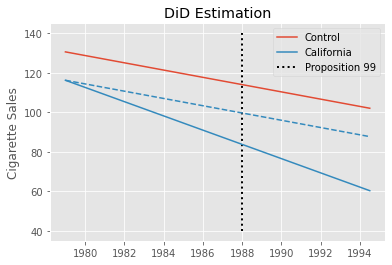

In [6]:
pre_year = data.query("~after_treatment")["year"].mean()
post_year = data.query("after_treatment")["year"].mean()

pre_control_y = did_model.params["Intercept"]
post_control_y = did_model.params["Intercept"] + did_model.params["after_treatment[T.True]"]

pre_treat_y = did_model.params["Intercept"] + did_model.params["treated[T.True]"]

post_treat_y1 = post_control_y + did_model.params["treated[T.True]"]

post_treat_y0 = post_treat_y1 + did_model.params["after_treatment[T.True]:treated[T.True]"]

plt.plot([pre_year, post_year], [pre_control_y, post_control_y], color="C0", label="Control")
plt.plot([pre_year, post_year], [pre_treat_y, post_treat_y1], color="C1", ls="dashed")
plt.plot([pre_year, post_year], [pre_treat_y, post_treat_y0], color="C1", label="California")

plt.vlines(x=1988, ymin=40, ymax=140, linestyle=":", lw=2, label="Proposition 99", color="black")
plt.title("DiD Estimation")
plt.ylabel("Cigarette Sales")
plt.legend();

This estimate should be taken with a grain of salt, though. We know that Diff-in-Diff requires the trend in the control group to be equal to that of the treatet group in the absense of the treatment. Formally, $E[Y(0)_{post, co} - Y(0)_{pre, co}] = E[Y(0)_{post, tr} - Y(0)_{pre, tr}]$. This is an untestable assumption, but looking at the pre-treatment trend of California (the treated unit) and the other states, we can get a feeling for how plausible it is. Specifically, we can see that the trend in `cigsale` for California is not parallel to the other states. Cigarette sales in California is decreasing faster than the average of the control states, even prior to the treatment. This will likly cause the DiD estimator to be downward biased, meaning that the true effect is less extreme than the one we've estimated above.

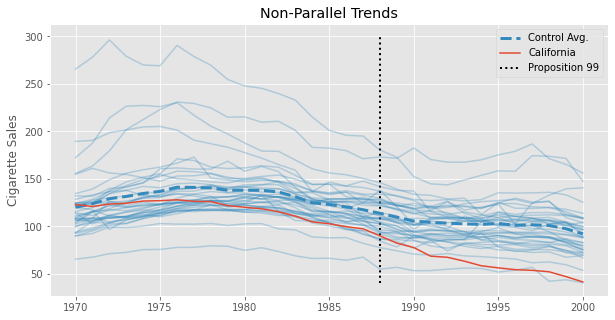

In [7]:
plt.figure(figsize=(10,5))
plt.plot(data_piv.drop(columns=["california"]), color="C1", alpha=0.3)
plt.plot(data_piv.drop(columns=["california"]).mean(axis=1), lw=3, color="C1", ls="dashed", label="Control Avg.")
plt.plot(data_piv["california"], color="C0", label="California")
plt.vlines(x=1988, ymin=40, ymax=300, linestyle=":", lw=2, label="Proposition 99", color="black")
plt.legend()
plt.ylabel("Cigarette Sales")
plt.title("Non-Parallel Trends");

The problem of non-parallel is where the synthetic control come into play in the Synthetic Diff-in-Diff model. But we are gueting ahead of ourselves. Regarthless of DiD being a valid model for the data above, what is interesting about it is that we can recast it into the Two-Way Fixed-Effects formulation. To frame DiD like this, we fit unit ($\alpha_i$) and time ($\beta_t$) averages, alongside the treatment indicator.

$$
\hat{\tau}^{did} = \underset{\mu, \alpha, \beta, \tau}{argmin} \bigg\{ \sum_{n=1}^N \sum_{t=1}^T \big(Y_{it} - (\mu + \alpha_i + \beta_t + \tau D_{it}\big)^2 \bigg\}
$$

In this formulation, the unit effects captures the difference in intercepts for each unit while the time effects capture the general trend across both treated and control unit. To implement this we could either add time and unit dummies to the moder or de-mean the data. In this process, we subtract the average across both time and units from both treatment and outcome variables:

$$
\ddot{Y}_{it} = Y_{it} - \bar{Y}_i  - \bar{T}_t\\
\ddot{D}_{it} = D_{it} - \bar{D}_i - \bar{D}_t
$$

Where, $\bar{X}_i$ is the average across all time periods for unit $i$ and $\bar{X}_t$ is the average across all units for time $t$: 

$$
\ddot{Y}_{it} = Y_{it} - T^{-1}\sum_{t=0}^{t=T} Y_{it}  - N^{-1}\sum_{i=0}^{i=N} Y_{it}\\
\ddot{D}_{it} = D_{it} - T^{-1}\sum_{t=0}^{t=T} D_{it} - N^{-1}\sum_{i=0}^{i=N} D_{it}
$$


After that de-meaning, a simple regression of the outcome on the treatment indicator (`treat*post`) yields the difference in difference estimator.

In [8]:
@curry
def demean(df, col_to_demean):
    return df.assign(**{col_to_demean: (df[col_to_demean]
                                        - df.groupby("state")[col_to_demean].transform("mean")
                                        - df.groupby("year")[col_to_demean].transform("mean"))})

formula = f"""cigsale ~ treat"""
mod = smf.ols(formula,
              data=data
              .assign(treat = data["after_treatment"]*data["treated"])
              .pipe(demean(col_to_demean="treat"))
              .pipe(demean(col_to_demean="cigsale")))

mod.fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-119.1647,0.333,-358.379,0.000,-119.817,-118.512
treat,-27.3491,4.283,-6.385,0.000,-35.753,-18.945


As you can see, we get the exact same parameter as before. After all, both approaches are simply different ways of looking at the same DiD estimator. However, the reason this formulation is much more interesting for our purpose is that it allows us to see how DiD is actually quise similar to Synthetic Controls. Take a very close look at the TWFE formulation above. Notice that it is a regression problem with time effects and unit effects. But notice how there are no weights in the optimization objective. That is the main difference between Diff-in-Diff and Synthetic Controls.

## Synthetic Controls Revisited

In the canonical Synthetic Control estimator, we find unit (state) weights that minimize the difference between the pre-treated outcome of the treated unit and the weighted average of pre-treated outcome of the control units (in a setting with no covariates). We also constraint the weights to be all positive and sum up to one. To find those weights, we solve the following optimization problem:

$$
\hat{w}^{sc} = \underset{w}{\mathrm{argmin}} \ ||\pmb{\bar{y}}_{pre, tr} - \pmb{Y}_{pre, co} \pmb{w}_{co}||^2_2 \\
\text{s.t } \ \sum w_i = 1 \text{ and } \ w_i > 0 \ \forall \ i
$$

where the outcome $\pmb{Y}_{pre, co}$ is a $T_{pre}$ by $N_{co}$ matrix, where the columns are the units and the rows are the time periods, and $\pmb{w}$ is a $N_{co}$ by 1 column vector, with one entry for each unit. Finally, $\pmb{\bar{y}}_{pre, tr}$ is a $T_{pre}$ by 1 column vector, where each entry is the time average of the treated units in the pre-treatment period.

Once we find the weights which solves the problem above, we can multiply them by the control units at all time periods to get a synthetic control for the treated unit:

$$
\pmb{y}_{sc} = \pmb{Y}_{co}\hat{\pmb{w}}^{sc}
$$

The idea here is that $\pmb{y}_{post, sc}$ is a good estimator for our missing poential outcome $Y(0)_{post, tr}$. If that is the case, the $ATT$ is simply the average of the treated unit in the post-treatment period minus the average of the synthetic control, also in the post treatment period.

$$
\hat{\tau} =  \bar{y}_{post, tr} - \bar{y}_{post, sc}
$$

In [9]:
from sc import SyntheticControl

sc_model = SyntheticControl()

y_co_pre = data.query("~after_treatment").query("~treated").pivot("year", "state", "cigsale")
y_tr_pre = data.query("~after_treatment").query("treated")["cigsale"]

sc_model.fit(y_co_pre, y_tr_pre)
sc_weights = pd.Series(sc_model.w_, index=y_co_pre.columns, name="sc_w")

sc = data.query("~treated").pivot("year", "state", "cigsale").dot(sc_weights)

att = data.query("treated")["cigsale"][sc.index > 1988].mean() - sc[sc.index > 1988].mean()

print("SC ATT: ", att.round(4))

SC ATT:  -19.5136


This estimate is much smaller than the one we got with Diff-in-Diff. Synthetic Controls doesn't require parallel trends, so it is not suceptible to the same bias as Diff-in-Diff. Rather, the process of baking a synthetic control enforces parallel trends, at least in the pre-treatment period. 

We can visualize this estimation process by ploting the realized outcome for California alongside the outcme of the synthetic control. We also plot as dashed lines the post intervention average of both California and the synthetic control. The difference between these lines is the estimated $ATT$.

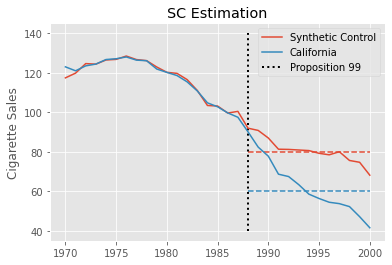

In [10]:
plt.plot(sc, label="Synthetic Control")
plt.plot(sc.index, data.query("treated")["cigsale"], label="California", color="C1")

calif_avg = data.query("treated")["cigsale"][sc.index > 1988].mean()
sc_avg = sc[sc.index > 1988].mean()

plt.hlines(calif_avg, 1988, 2000, color="C1", ls="dashed")
plt.hlines(sc_avg, 1988, 2000, color="C0", ls="dashed")

plt.title("SC Estimation")
plt.ylabel("Cigarette Sales")
plt.vlines(x=1988, ymin=40, ymax=140, linestyle=":", lw=2, label="Proposition 99", color="black")
plt.legend();

Interestigly enough, we can also recast the Synthetic Control estimator as solving the following optimization problem, which is quite similar to the Two-Way Fixed-Effects formulation we used for Diff-in-Diff

$$
\hat{\tau}^{sc} = \underset{\beta, \tau}{argmin}  \bigg\{ \sum_{n=1}^N \sum_{t=1}^T \big(Y_{it} - \beta_t - \tau D_{it}\big)^2 \hat{w}^{sc}_i \bigg\}
$$

where $\hat{w}^{sc}_i$ for the control units are estimated from the optimization problem we saw earlier. For the treated unit,  the weights are simply $1/N_{tr}$ (unifor weighting). 

Notice the difference between SC and DiD here. First, Synthetic Control adds wights $\hat{w}^{sc}_i$ to the equation. Second, we have time fixed effects $\beta_t$ but no unit fixed effect $\alpha_i$ nor an overall intercept  $\mu$. 

To verify that these two formulations are actually equivalent, here is the code for it, which yields the exact same $ATT$ estimate. 

In [11]:
@curry
def demean_time(df, col_to_demean):
    return df.assign(**{col_to_demean: (df[col_to_demean]
                                        - df.groupby("year")[col_to_demean].transform("mean"))})

data_w_cs_weights = data.set_index("state").join(sc_weights).fillna(1/len(sc_weights))

formula = f"""cigsale ~ -1 + treat"""

mod = smf.wls(formula,
              data=data_w_cs_weights
              .assign(treat = data_w_cs_weights["after_treatment"]*data_w_cs_weights["treated"])
              .pipe(demean_time(col_to_demean="treat"))
              .pipe(demean_time(col_to_demean="cigsale")),
              weights=data_w_cs_weights["sc_w"]+1e-10)

mod.fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
treat,-19.5136,13.289,-1.468,0.142,-45.586,6.559


We just saw how the two approaches, SC and DiD, are actually closely related. Now, we are ready to talk about Synthetic Diff-in-Diff. As you can probably guess, we will just add weights to the DiD estimator or unit fixed-fffects to the Synthetic Control estimator.

## Synthetic Diff-in-Diff

Before we jump right into the Synthetic Diff-in-Diff estimator, let me just reproduce the same equations we saw earlier for SC and DiD, which will ease the comparisson.

$$
\hat{\tau}^{sc} = \underset{\beta, \tau}{argmin}  \bigg\{ \sum_{n=1}^N \sum_{t=1}^T \big(Y_{it} - \beta_t - \tau D_{it}\big)^2 \hat{w}^{sc}_i \bigg\}
$$

$$
\hat{\tau}^{did} = \underset{\mu, \alpha, \beta, \tau}{argmin} \bigg\{ \sum_{n=1}^N \sum_{t=1}^T \big(Y_{it} - (\mu + \alpha_i + \beta_t + \tau D_{it}\big)^2 \bigg\}
$$

Next, just like I promissed, we can easily merge the equations above into one which contains elements from both of them:

$$
\hat{\tau}^{sdid} = \underset{\mu, \alpha, \beta, \tau}{argmin}  \bigg\{ \sum_{n=1}^N \sum_{t=1}^T \big(Y_{it} - (\mu + \alpha_i + \beta_t + \tau D_{it}\big)^2 \hat{w}^{sdid}_i \hat{\lambda}^{sdid}_t \bigg\}
$$

As you can see, we've added back the $\alpha_i$ unit fixed effects, just like I promised. We've also kept the unit weights $\hat{w}_i$. But there is something new, which is the time weights $\hat{\lambda}_t$. Don't worry. There is nothing fancy about them. Remember how the unit weights $w_i$ minimized the difference between the control units and the average of treated units? In other words, we use them to match the pre-trend of the treated and control groups. The time weight does the same thing, but for the periods. That is, it minimizes the difference between the pre and post-treated periods. 

$$
\hat{\lambda}^{sdid} = \underset{\lambda}{\mathrm{argmin}} \ ||\bar{\pmb{y}}_{post, co} - (\pmb{\lambda}_{pre} \pmb{Y}_{pre, co} +  \lambda_0)||^2_2 \\
\text{s.t } \ \sum \lambda_t = 1 \text{ and } \ \lambda_t > 0 \ \forall \ t
$$

Again, $\pmb{Y}_{pre, co}$ is a $T_{pre}$ by $N_{co}$ matrix of outcomes where the rows represent time periods and the columns represents the units. But now $\bar{\pmb{y}}_{post, co}$ is a 1 by $N_{co}$ row vector, where each unit is the time average outcome for that control unit in the post-treatment period. Finally, $\pmb{\lambda}_{pre}$ is a 1 by $T_{pre}$ row vector, with one entry for each pre-treatment period. Another way to see this is by noticing that the unit weights $w$ where multiplying after outcome matrix $\pmb{Y}_{pre, co} \pmb{w}_{co}$. This means we where regressing the average outcome **for each unit** for the treated group on the outcome of the units in the control group. Now, we are fliping that problem on its head, regressing the average outcome **for each post-treatment time period** for the control group on the outcome of the same control units, but on the pre-treatment period.

As for the time weights in the post-treated periods, we just set them to one over the number of post treated periods $1/T_{post}$ (again, doing unifor weighting). Notice that we also have an intercept $\lambda_0$. We do this to allow the post-treatment period to be above or below all the pre-treatment periods, which is the case in many applications with a clear positive or negative trend, including this one.

If all of this seems a bit abstract, maybe to code will help you understand what is going on.

In [12]:
def fit_time_weights(data, outcome_col, year_col, state_col, treat_col, post_col):
        
        control = data.query(f"~{treat_col}")
        
        # pivot the data to the (T_pre, N_co) matrix representation
        y_pre = (control
                 .query(f"~{post_col}")
                 .pivot(year_col, state_col, outcome_col))
        
        # group post-treatment time period by units to have a (1, N_co) vector.
        y_post_mean = (control
                       .query(f"{post_col}")
                       .groupby(state_col)
                       [outcome_col]
                       .mean()
                       .values)
        
        # add a (1, N_co) vector of 1 to the top of the matrix, to serve as the intercept.
        X = np.concatenate([np.ones((1, y_pre.shape[1])), y_pre.values], axis=0)
        
        # estimate time weights
        w = cp.Variable(X.shape[0])
        objective = cp.Minimize(cp.sum_squares(w@X - y_post_mean))
        constraints = [cp.sum(w[1:]) == 1, w[1:] >= 0]
        problem = cp.Problem(objective, constraints)
        problem.solve(verbose=False)
        
        # print("Intercept: ", w.value[0])
        return pd.Series(w.value[1:], # remove intercept
                         name="time_weights",
                         index=y_pre.index)

The first thing we do in this code is to filter out the treated group. Then, we pivot the pre-treated data so that we have the matrix $\pmb{Y}_{pre,co}$. Next, we group the post-treatment data to get the average outcome for each control unit in the post-treatment period. We then add a row full of ones to the top of $\pmb{Y}_{pre,co}$, which will serve as the intercept. Finally, we regress $\bar{\pmb{y}}_{post, co}$ on the pre-treated periods (the rows of $\pmb{Y}_{pre,co}$) to get the time weights $\lambda_t$. Notice how we add the constrains to have the weights sum up to 1 and be non-negative. Finally, we toss the intercept away and store the time weights in a series. 

Here is the result we get by runing the code above to find the time weights in the Proposition 99 problem. Notice that all periods execpt for 1986, 87 ans 88 get zero weights. This means that a weighted average of only the last 3 periods is enougth to balance pre and post treatment periods.

In [13]:
time_weights = fit_time_weights(data,
                                outcome_col="cigsale",
                                year_col="year",
                                state_col="state",
                                treat_col="treated",
                                post_col="after_treatment")

time_weights.round(3).tail()

year
1984   -0.000
1985   -0.000
1986    0.366
1987    0.206
1988    0.427
Name: time_weights, dtype: float64

To understand a bit more about the role of these weights, we can plot $\hat{\pmb{\lambda}}_{pre} \pmb{Y}_{pre, co} +  \hat{\lambda}_0$ as a horizontal line in the pre-treatment period that doesn't get zerod out. Next to it, we plot the average outcome in the post-treatment period. Notice how they alight perectly. We also show the estimated time weights in red bars and in the secondary axis.

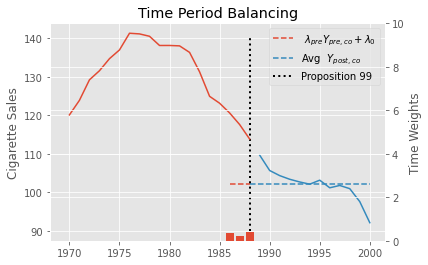

In [52]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(data.query("~treated").query("~after_treatment").groupby("year")["cigsale"].mean())
ax.plot(data.query("~treated").query("after_treatment").groupby("year")["cigsale"].mean())

intercep = -15.023877689807628
ax.hlines((data.query("~treated").query("~after_treatment").groupby("year")["cigsale"].mean() * time_weights).sum() - 15, 1986, 1988,
          color="C0", ls="dashed", label=""" $\lambda_{pre} Y_{pre, co} + \lambda_0$""")
ax.hlines(data.query("~treated").query("after_treatment").groupby("year")["cigsale"].mean().mean(), 1988, 2000,
          color="C1", ls="dashed", label="""Avg  $Y_{post, co}$""")
ax.vlines(x=1988, ymin=90, ymax=140, linestyle=":", lw=2, label="Proposition 99", color="black")
plt.legend()

plt.title("Time Period Balancing")
plt.ylabel("Cigarette Sales");

ax2 = ax.twinx()
ax2.bar(time_weights.index, time_weights, label="$\lamba$")
ax2.set_ylim(0,10)
ax2.set_ylabel("Time Weights");

Now that we learned what are the time weights $\lambda_t$ in the Synthetic-Diff-in-Diff estimator and how to estimate them, lets turn our atention to the unit weights $w_i$. And no, unfortunatly they are not just like the ones we get when using traditional Synthetic Controls. The first difference between them is that we also allows for an intercept $w_0$. We do this because we don't need the treated unit and synthetic control to have the same level anymore. Since we will through DiD into the mix, we only need to make the synthetic control and treated unit have parallel trends.

The next difference is that we add a $L_2$ penalty to the weighs. This helps non-zero weights to be more distributed across the control units, as oposed to having just a few of them contributing to the Synthetic Control. The $L_2$ penalty ensure we don't have very big weights, wich foces us to use more units. 


$$
\hat{w}^{sdid} = \underset{w}{\mathrm{argmin}} \ ||\bar{\pmb{y}}_{pre, tr} - (\pmb{Y}_{pre, co} \pmb{w}_{co} +  w_0)||^2_2 + \zeta^2 T_{pre} ||\pmb{w}_{co}||^2_2\\
\text{s.t } \ \sum w_i = 1 \text{ and } \ w_i > 0 \ \forall \ i
$$


There is also this $\zeta^2$ term, which is theoretically motivated, but very complicated to exaplain, so I will unfortunatly leave as a bit of a mistery. We define it like this:

$$
\zeta = (N_{tr}* T_{post})^{1/4}\sigma(\Delta_{it})
$$

where $\Delta_{it}$ is the first difference in the outcomes $Y_{it} - Y_{i(t-1)}$ and $\sigma(\Delta_{it})$ is the standard deviation of this diference. Here is the code to compute it.

In [15]:
def calculate_regularization(data, outcome_col, year_col, state_col, treat_col, post_col):
    
    n_treated_post = data.query(post_col).query(treat_col).shape[0]
    
    first_diff_std = (data
                      .query(f"~{post_col}")
                      .query(f"~{treat_col}")
                      .groupby(state_col)
                      [outcome_col]
                      .diff()
                      .std())
    
    return n_treated_post**(1/4) * first_diff_std

As for the unit weights, there is nothing particularly fancy. We can reuse a lot of the code from the function to estimate the time weights. We only need to be carefull about the dimensions, since the problem is now upside down.

In [48]:
def fit_unit_weights(data, outcome_col, year_col, state_col, treat_col, post_col):
    
    zeta = calculate_regularization(data, outcome_col, year_col, state_col, treat_col, post_col)
    pre_data = data.query(f"~{post_col}")
    
    # pivot the data to the (T_pre, N_co) matrix representation
    y_pre_control = (pre_data
                     .query(f"~{treat_col}")
                     .pivot(year_col, state_col, outcome_col))
    
    # group treated units by time periods to have a (T_pre, 1) vector.
    y_pre_treat_mean = (pre_data
                        .query(f"{treat_col}")
                        .groupby(year_col)
                        [outcome_col]
                        .mean())
    
    # add a (T_pre, 1) column to the begining of the (T_pre, N_co) matrix  serve as intercept
    T_pre = y_pre_control.shape[0]
    X = np.concatenate([np.ones((T_pre, 1)), y_pre_control.values], axis=1) 
    
    # estimate time weights. Notice the L2 penalty using zeta
    w = cp.Variable(X.shape[1])
    objective = cp.Minimize(cp.sum_squares(X@w - y_pre_treat_mean.values) + T_pre*zeta**2 * cp.sum_squares(w[1:]))
    constraints = [cp.sum(w[1:]) == 1, w[1:] >= 0]
    
    problem = cp.Problem(objective, constraints)
    problem.solve(verbose=False)
    
    # print("Intercept:", w.value[0])
    return pd.Series(w.value[1:], # remove intercept
                     name="unit_weights",
                     index=y_pre_control.columns)

First, we calculate $\zeta$ using the functions we defined earlier and filter out the post-treatment period. Next, we pivot the pre-treatment data to get the $\bar{\pmb{y}}_{pre, tr}$ matrix of outcomes. Then, we add a column full of ones to the begining of the $\bar{\pmb{y}}_{pre, tr}$ matrix. This colun will allow us to estimate the intercept. With all of that, we define the optimization objective, which includes the $L_2$ penality on the weights. Finally, we toss the intercept away and store the estimated weights in a series.

If we use this codie to estimate the unit weights in the Propostion 99 problem, here is the result we get for the first 5 states:

In [47]:
unit_weights = fit_unit_weights(data,
                                outcome_col="cigsale",
                                year_col="year",
                                state_col="state",
                                treat_col="treated",
                                post_col="after_treatment")

unit_weights.round(3).head()

-24.75035353644767


state
1   -0.000
2   -0.000
4    0.057
5    0.078
6    0.070
Name: unit_weights, dtype: float64

These unit weights also define a synthetic control unit that we can plot alongside the outcome of California. I'll also plot the traditional synthetic control we fited earlier shifted by the same intercept we've just estimated. This will give us some intuition on what is going on and the difference between what we just did and traditional Synthetic Control.

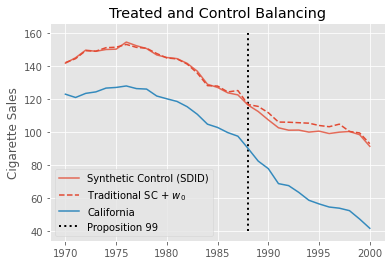

In [54]:
intercept = -24.75035353644767
sc_did = data_piv.drop(columns="california").values @ unit_weights.values

plt.plot(data_piv.index, sc_did, label="Synthetic Control (SDID)", color="C0", alpha=.8)
plt.plot(data_piv.index, sc-intercept, label="Traditional SC + $w_0$", color="C0", ls="dashed")
plt.plot(data_piv["california"], label="California", color="C1")

plt.vlines(x=1988, ymin=40, ymax=160, linestyle=":", lw=2, label="Proposition 99", color="black")
plt.legend()
plt.title("Treated and Control Balancing")
plt.ylabel("Cigarette Sales");

As we can see, the obvious difference is that California and its synthetic control are no longer on top of each other. That is because we've included an intercept, 

In [19]:
def join_weights(data, unit_w, time_w, year_col, state_col, treat_col, post_col):

    return (
        data
        .set_index([year_col, state_col])
        .join(time_w)
        .join(unit_w)
        .reset_index()
        .fillna({time_w.name: data[post_col].mean(),
                 unit_w.name: data[treat_col].mean()})
        .assign(**{"weights": lambda d: d[time_w.name]*d[unit_w.name]})
        .astype({treat_col:int, post_col:int}))

In [20]:
did_data = join_weights(data, unit_weights, time_weights,
                        year_col="year",
                        state_col="state",
                        treat_col="treated",
                        post_col="after_treatment")

did_data.head()

,year,state,cigsale,treated,after_treatment,time_weights,unit_weights,weights
0,1970,1,89.800003,0,0,-4.600041e-14,-1.360835e-16,6.259896e-30
1,1971,1,95.400002,0,0,-4.582326e-14,-1.360835e-16,6.235789e-30
2,1972,1,101.099998,0,0,-5.274204e-14,-1.360835e-16,7.177320e-30
3,1973,1,102.900002,0,0,-5.766365e-14,-1.360835e-16,7.847071e-30
4,1974,1,108.199997,0,0,-5.617991e-14,-1.360835e-16,7.645158e-30


In [21]:
did_model = smf.wls("cigsale ~ after_treatment*treated",
                    data=did_data,
                    weights=did_data["weights"]+1e-10).fit()

did_model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,120.4060,1.965,61.278,0.000,116.551,124.261
after_treatment,-19.1905,2.166,-8.859,0.000,-23.440,-14.941
treated,-25.2601,12.427,-2.033,0.042,-49.641,-0.879
after_treatment:treated,-15.6054,13.700,-1.139,0.255,-42.483,11.272


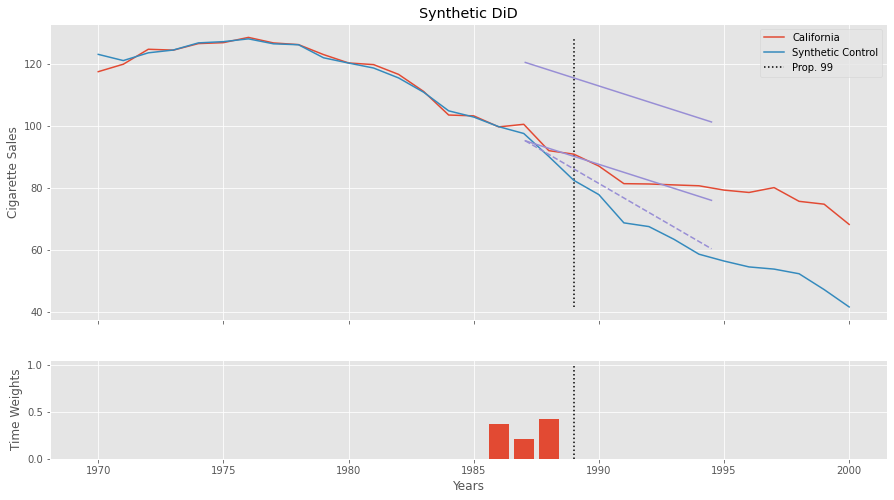

In [22]:
avg_pre_period = (time_weights * time_weights.index).sum()
avg_post_period = 1989 + (2000 - 1989) / 2

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,8), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

ax1.plot(data_piv.index, sc_did, label="California")
ax1.plot(data_piv.index, data_piv["california"], label="Synthetic Control")
ax1.vlines(1989, data_piv["california"].min(), sc_did.max(), color="black", ls="dotted", label="Prop. 99")

pre_sc = did_model.params["Intercept"]
post_sc = pre_sc + did_model.params["after_treatment"]
pre_treat = pre_sc + did_model.params["treated"]
post_treat = post_sc + did_model.params["treated"] + did_model.params["after_treatment:treated"]

sc_did_y0 = pre_treat + (post_sc - pre_sc)

ax1.plot([avg_pre_period, avg_post_period], [pre_sc, post_sc], color="C2")
ax1.plot([avg_pre_period, avg_post_period], [pre_treat, post_treat], color="C2", ls="dashed")
ax1.plot([avg_pre_period, avg_post_period], [pre_treat, sc_did_y0], color="C2")
ax1.legend()
ax1.set_title("Synthetic DiD")
ax1.set_ylabel("Cigarette Sales")

ax2.bar(time_weights.index, time_weights)
ax2.vlines(1989, 0, 1, color="black", ls="dotted")
ax2.set_ylabel("Time Weights")
ax2.set_xlabel("Years");

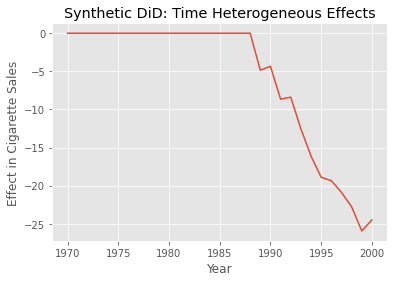

In [23]:
model = smf.wls("cigsale ~ treated:after_treatment:C(year) + C(state) + C(year)",
        data=did_data,
        weights=did_data["weights"] + 1e-10,
       ).fit()

effect = pd.Series(model.params[model.params.index.str.contains("treated")].values,
                   index=sorted(did_data["year"].unique()))
effect.plot()
plt.title("Synthetic DiD: Time Heterogeneous Effects")
plt.ylabel("Effect in Cigarette Sales")
plt.xlabel("Year");

In [24]:
def synthetic_diff_in_diff(data, outcome_col, year_col, state_col, treat_col, post_col, formula=None):
    
    unit_weights = fit_unit_weights(data,
                                    outcome_col=outcome_col,
                                    year_col=year_col,
                                    state_col=state_col,
                                    treat_col=treat_col,
                                    post_col=post_col)
    
    time_weights = fit_time_weights(data,
                                    outcome_col=outcome_col,
                                    year_col=year_col,
                                    state_col=state_col,
                                    treat_col=treat_col,
                                    post_col=post_col)

    did_data = join_weights(data, unit_weights, time_weights,
                            year_col=year_col,
                            state_col=state_col,
                            treat_col=treat_col,
                            post_col=post_col)

    formula = f"{outcome_col} ~ {post_col}*{treat_col}" if formula is None else formula
    did_model = smf.wls(formula, data=did_data, weights=did_data["weights"]+1e-10).fit()
    params = did_model.params
    
    return pd.Series(params[params.index.str.contains(f"{post_col}") & params.index.str.contains(f"{treat_col}")])
    

In [25]:
effect = synthetic_diff_in_diff(data, 
                                outcome_col="cigsale",
                                year_col="year",
                                state_col="state",
                                treat_col="treated",
                                post_col="after_treatment")

In [26]:
effect

after_treatment:treated   -15.605399
dtype: float64

In [27]:
effects_by_year = synthetic_diff_in_diff(data, 
                                         outcome_col="cigsale",
                                         year_col="year",
                                         state_col="state",
                                         treat_col="treated",
                                         post_col="after_treatment",
                                         formula="cigsale ~ treated:after_treatment:C(year) + C(state) + C(year)")

In [28]:
effects_by_year.round(3)

treated:after_treatment:C(year)[1970]     0.000
treated:after_treatment:C(year)[1971]     0.000
treated:after_treatment:C(year)[1972]     0.000
treated:after_treatment:C(year)[1973]     0.000
treated:after_treatment:C(year)[1974]     0.000
treated:after_treatment:C(year)[1975]    -0.000
treated:after_treatment:C(year)[1976]    -0.000
treated:after_treatment:C(year)[1977]    -0.000
treated:after_treatment:C(year)[1978]    -0.000
treated:after_treatment:C(year)[1979]     0.000
treated:after_treatment:C(year)[1980]    -0.000
treated:after_treatment:C(year)[1981]    -0.000
treated:after_treatment:C(year)[1982]     0.000
treated:after_treatment:C(year)[1983]     0.000
treated:after_treatment:C(year)[1984]     0.000
treated:after_treatment:C(year)[1985]     0.000
treated:after_treatment:C(year)[1986]     0.000
treated:after_treatment:C(year)[1987]     0.000
treated:after_treatment:C(year)[1988]     0.000
treated:after_treatment:C(year)[1989]    -4.844
treated:after_treatment:C(year)[1990]   

## Placebo Variance Estimation

In [29]:
def make_random_placebo(data, state_col, treat_col):
    control = data.query(f"~{treat_col}")
    states = control[state_col].unique()
    placebo_state = np.random.choice(states, replace=False)
    
    return control.assign(**{treat_col: control[state_col] == placebo_state})

In [30]:
np.random.seed(1)
placebo_data = make_random_placebo(data, state_col="state", treat_col="treated")
placebo_data.tail()

,state,year,cigsale,treated,after_treatment
1204,39,1996,110.300003,False,True
1205,39,1997,108.800003,False,True
1206,39,1998,102.900002,False,True
1207,39,1999,104.800003,False,True
1208,39,2000,90.500000,False,True


In [31]:
def estimate_se(data, outcome_col, year_col, state_col, treat_col, post_col, bootstrap_rounds=400, formula=None, seed=0):
    np.random.seed(seed=seed)
    effects = [synthetic_diff_in_diff(make_random_placebo(data, state_col=state_col, treat_col=treat_col), 
                                      outcome_col=outcome_col,
                                      year_col=year_col,
                                      state_col=state_col,
                                      treat_col=treat_col,
                                      post_col=post_col,
                                      formula=formula,)
              for _ in range(bootstrap_rounds)]
    
    return np.std(effects, axis=0)


In [32]:
effect = synthetic_diff_in_diff(data,
                                outcome_col="cigsale",
                                year_col="year",
                                state_col="state",
                                treat_col="treated",
                                post_col="after_treatment")


se = estimate_se(data,
                 outcome_col="cigsale",
                 year_col="year",
                 state_col="state",
                 treat_col="treated",
                 post_col="after_treatment")

In [33]:
print(f"Effect: {effect['after_treatment:treated']}")
print(f"Standard Error: {se[0]}")

Effect: -15.605398734600275
Standard Error: 8.927635522088968


In [34]:
print(f"90% CI: ({effect['after_treatment:treated']-1.65*se[0]}, {effect['after_treatment:treated']+1.65*se[0]})")

90% CI: (-30.335997346047073, -0.874800123153479)


In [35]:
effect = synthetic_diff_in_diff(data,
                                outcome_col="cigsale",
                                year_col="year",
                                state_col="state",
                                treat_col="treated",
                                post_col="after_treatment",
                                formula="cigsale ~ treated:after_treatment:C(year) + C(state) + C(year)")


se = estimate_se(data,
                 outcome_col="cigsale",
                 year_col="year",
                 state_col="state",
                 treat_col="treated",
                 post_col="after_treatment",
                 formula="cigsale ~ treated:after_treatment:C(year) + C(state) + C(year)")

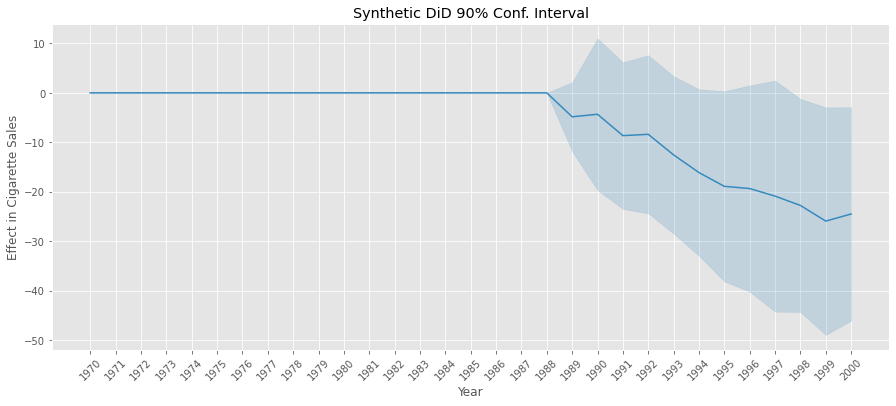

In [36]:
plt.figure(figsize=(15,6))
years = effect.index.astype(str).str.split(r"\[|\]").str[-2]

plt.plot(years, effect, color="C1")
plt.fill_between(years, effect-1.65*se, effect+1.65*se, alpha=0.2,  color="C1")

plt.ylabel("Effect in Cigarette Sales")
plt.xlabel("Year")
plt.title("Synthetic DiD 90% Conf. Interval")
plt.xticks(rotation=45);

In [37]:
def synthetic_control(data, outcome_col, year_col, state_col, treat_col, post_col):
    
    x_pre_control = (data
                     .query(f"~{treat_col}")
                     .query(f"~{post_col}")
                     .pivot(year_col, state_col, outcome_col)
                     .values)
    
    y_pre_treat_mean = (data
                        .query(f"~{post_col}")
                        .query(f"{treat_col}")
                        .groupby(year_col)
                        [outcome_col]
                        .mean())
    
    w = cp.Variable(x_pre_control.shape[1])
    objective = cp.Minimize(cp.sum_squares(x_pre_control@w - y_pre_treat_mean.values))
    constraints = [cp.sum(w) == 1, w >= 0]
    
    problem = cp.Problem(objective, constraints)
    problem.solve(verbose=False)
    
    sc = (data
          .query(f"~{treat_col}")
          .pivot(year_col, state_col, outcome_col)
          .values) @ w.value
    
    y1 = data.query(f"{treat_col}").query(f"{post_col}")[outcome_col]
    att = np.mean(y1 - sc[-len(y1):])
    
    return att


def estimate_se_sc(data, outcome_col, year_col, state_col, treat_col, post_col, bootstrap_rounds=400, seed=0):
    np.random.seed(seed=seed)
    effects = [synthetic_control(make_random_placebo(data, state_col=state_col, treat_col=treat_col), 
                                 outcome_col=outcome_col,
                                 year_col=year_col,
                                 state_col=state_col,
                                 treat_col=treat_col,
                                 post_col=post_col)
              for _ in range(bootstrap_rounds)]
    
    return np.std(effects, axis=0)


effect_sc = synthetic_control(data,
                              outcome_col="cigsale",
                              year_col="year",
                              state_col="state",
                              treat_col="treated",
                              post_col="after_treatment")


se_sc = estimate_se_sc(data,
                       outcome_col="cigsale",
                       year_col="year",
                       state_col="state",
                       treat_col="treated",
                       post_col="after_treatment")

In [38]:
print(f"Effect: {effect_sc}")
print(f"Standard Error: {se_sc}")

print(f"90% CI: ({effect_sc-1.65*se_sc}, {effect_sc+1.65*se_sc})")

Effect: -19.513629763998537
Standard Error: 10.398847371533353
90% CI: (-36.67172792702857, -2.3555316009685043)
